In [1]:
%matplotlib inline
# load plotting tools
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.ticker as mtick
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits import mplot3d
# load numpy
import numpy as np
# import scipy for pile plotting
import scipy.optimize
# load os and cli manipulators
import os
import subprocess

In [2]:
# get the number of generations by counting the number of files
genNo = len(os.listdir('./data'))
# get te number of individuals by counting the number of lines
indNo = sum(1 for line in open('./data/gen0.txt'))
# the shell command to get the number of variables+1 is
# 'head -1 ./data/gen0.txt | grep -o "," | wc -l'
# which is equivalent to the next python commands
sampleInd = subprocess.Popen(('head', '-1', './data/gen0.txt'), stdout=subprocess.PIPE)
elements = subprocess.check_output(('grep', '-o', ','), stdin=sampleInd.stdout)
varNo = str(elements).count(',')-1
# store all generations, individuals and variables + 2 objectives
gen = np.zeros((genNo,indNo,varNo+2))
# read the files
for i in range(genNo):
    gen[i,:] = np.genfromtxt('./data/gen%d.txt' %i, delimiter=',')

In [3]:
# define the plot
fig, ax1 = plt.subplots(1, figsize=(12,10))
# 'close' the figure to avoid extra empty axis
plt.close()
# define init function
def init():
    ax1.clear()
    ax1.axis([3e3,13e3,1e5,9e5])
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_xlabel('Total heat transfer ($W$)', fontsize=20)
    ax1.set_ylabel('Air surface ($m^2$)', fontsize=20)
    ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    ax1.set_title('Snow pile optimization', fontsize=24)

# define function with generation as variable
def animate(iGen):
    for i in range(iGen):
        # this time just each 10 generations will be represented
        newgen, = ax1.plot(gen[10*i,:,-1],gen[10*i,:,-2], 
                          '.',markersize=i,alpha=1-i*0.5/genNo,
                          c=plt.cm.viridis((10*i+1)/genNo))

# create the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=int(genNo/10+1))
# call the animation
ani

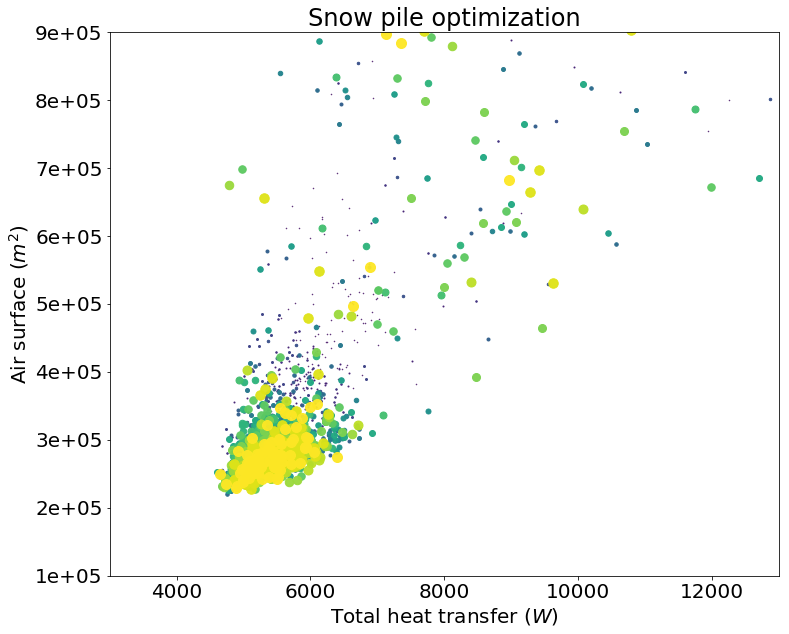

In [4]:
# define the plot
fig, ax1 = plt.subplots(1, figsize=(12,10))
ax1.axis([3e3,13e3,1e5,9e5])
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('Total heat transfer ($W$)', fontsize=20)
ax1.set_ylabel('Air surface ($m^2$)', fontsize=20)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax1.set_title('Snow pile optimization', fontsize=24)

for i in range(int(genNo/10)+1):
    ax1.plot(gen[10*i,:,-1],gen[10*i,:,-2], '.',markersize=i,alpha=1-i*0.5/genNo,
             c=plt.cm.viridis((10*i+1)/genNo))


Opposed to what was expected, there is not a clear Pareto front. This means that there is an optimal design that will provide both the less amount of heat transfer and the smaller surface in contact with the aire (which will be the surface that will have to be insulated and, therefore, will have an associated cost). Let's analyze this design optimized point, where both objectives are minimum at the same time.

In [5]:
optPt = gen[np.unravel_index((gen[:,:,-1]+gen[:,:,-2]).argmin(), (genNo,indNo))]

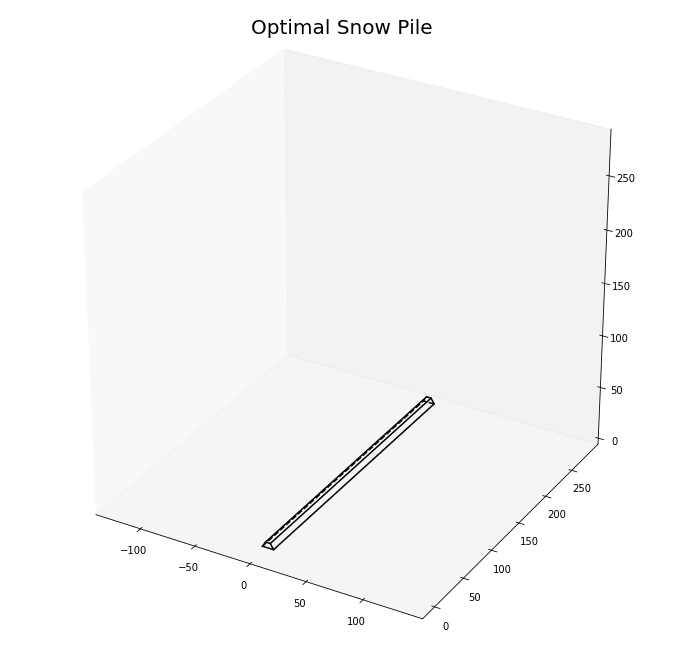

In [6]:
# get the parameters
alpha = optPt[0] 
b = optPt[1]
H = optPt[2]

# functions from snowPiile_notebook
def vol(alpha, b, H, l):
    b2 = b - 2*H*np.tan(np.deg2rad(90-alpha))
    frontArea = H*(b+b2)/2
    volume = frontArea*l
    return volume

# function for optimization
fVol = lambda l, b, H, alpha, fixedVol : vol(alpha, b, H, l)-fixedVol

# fixed volume of the pile
fixedVol = 10000

# get the length of a pile given by some (alpha, b, H) and volume
l = scipy.optimize.fsolve(fVol, 1e3, args=(b, H, alpha, fixedVol))

# plot the optimal pile
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.grid(False)
b2dif = H*np.tan(np.deg2rad(90-alpha))
ax.plot([b2dif,b-b2dif,b],[l,l,l],[H,H,0],'k')
ax.plot([b,0,b2dif],[l,l,l],[0,0,H],'k--')
ax.plot([0,b2dif,b-b2dif,b,0],[0,0,0,0,0],[0,H,H,0,0],'k')
ax.plot([0,0],[0,l],[0,0],'k--')
ax.plot([b2dif,b2dif],[0,l],[H,H],'k')
ax.plot([b-b2dif,b-b2dif],[0,l],[H,H],'k')
ax.plot([b,b],[0,l],[0,0],'k')
ax.set_xlim([b/2-l/2,b/2+l/2])
ax.set_zlim([0,H+l])
ax.set_title('Optimal Snow Pile', fontsize=20, pad=25);